## Experiment-0:  MNIST - Model Check

Training params:
    - Network: VAE
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 28 x 28
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.mnist import MNISTDataModule
import torch
from src.models.vae.vae import VAE
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
mnist = MNISTDataModule(resize=True)

mnist.prepare_data()
mnist.setup()

experiment_name = 'VAE_MNIST_Full_Image'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=5,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=20, gpus=1, logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)


EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
model = VAE(lr=1e-3)

trainer.fit(model, mnist)

Set SLURM handle signals.

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11 M  
1 | decoder | ResNetDecoder | 8 M   
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 


1

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
path.mkdir(parents=True, exist_ok=True)


trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_VAE_full_img = VAE(lr=1e-3).load_from_checkpoint(checkpoint_path=model_path).cuda()
eval_VAE_full_img.eval()
test = mnist.test_dataloader()

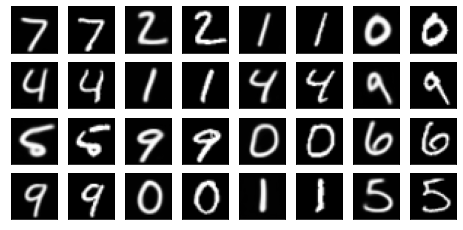

In [8]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= (columns * rows) * 2:
        fig.add_subplot(rows * 2, columns * 2, i)
        img = img[0][0]
        img = img.repeat(1, 3, 1, 1)
        out = eval_VAE_full_img(img.cuda())
        reconstructed_img = out[0, 0, :, :]
        plt.imshow(reconstructed_img.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        
        fig.add_subplot(rows * 2, columns * 2, i+1)
        plt.imshow(img[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 2
plt.show()

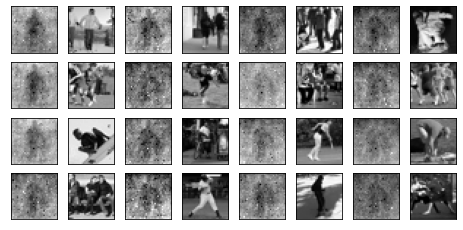

In [8]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= (columns * rows) * 2:
        fig.add_subplot(rows * 2, columns * 2, i)
        img = img[0][0]
        img = img.repeat(1, 3, 1, 1)
        out = eval_VAE_full_img(img.cuda())
        reconstructed_img = out[0, 0, :, :]
        plt.imshow(reconstructed_img.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        
        fig.add_subplot(rows * 2, columns * 2, i+1)
        plt.imshow(img[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 2
plt.show()